###**✅This is our general pipeline for predicting BBB+/BBB- class labels and exact logBB values of organic chemical compounds**

In [80]:
!pip install rdkit

In [81]:
!pip install lightgbm

In [82]:
!pip install pubchempy

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from lightgbm import LGBMRegressor
from matplotlib import rcParams
from pubchempy import *
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors, GraphDescriptors, Lipinski, QED, rdMolDescriptors, Fragments, FragmentMatcher
from rdkit.Chem.EState.EState_VSA import VSA_EState_
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

### **Data uploading**

In [149]:
filename = 'smiles.csv' # write the name of your file here
df = pd.read_csv(filename)
df.head()

,SMILES
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
1,OCC(O)C(O)C(O)C(O)CO
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...


In [150]:
for i, row in df.iterrows():
  try:
    df.at[i, 'SMILES'] = Chem.CanonSmiles(row.SMILES) # bring all smiles to canonical
  except:
    pass

In [152]:
df = df.drop_duplicates()

### **Generation of basic RDKit features**

### QED and Crippen modules

In [85]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    qed_vector = QED.properties(mol)
    df.at[i, 'MW'] = round(qed_vector[0], 2)
    df.at[i, '#HBA'] = qed_vector[2]
    df.at[i, '#HBD'] = qed_vector[3]
    df.at[i, 'PSA'] = qed_vector[4]
    df.at[i, '#ROTB'] = qed_vector[5]
    df.at[i, '#ALERTS'] = qed_vector[7]

    df.at[i, 'MlogP'] = round(Crippen.MolLogP(mol), 2)
    df.at[i, '#MR'] = round(Crippen.MolMR(mol), 2)

df.head()

,SMILES,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20
1,OCC(O)C(O)C(O)C(O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05


### Lipinski module

In [86]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, '#HeavyAtoms'] = Lipinski.HeavyAtomCount(mol)
    df.at[i, '#NHOH'] = Lipinski.NHOHCount(mol)
    df.at[i, '#NO'] = Lipinski.NOCount(mol)
    df.at[i, '#AromaticCarbocycles'] = Lipinski.NumAromaticCarbocycles(mol)
    df.at[i, '#AromaticHeterocycles'] = Lipinski.NumAromaticHeterocycles(mol)
    df.at[i, '#Heteroatoms'] = Lipinski.NumHeteroatoms(mol)

df.head()

,SMILES,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,#NHOH,#NO,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,6.0,6.0,0.0,0.0,6.0
1,OCC(O)C(O)C(O)C(O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,6.0,6.0,0.0,0.0,6.0
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,19.0,5.0,6.0,1.0,1.0,7.0
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,29.0,2.0,5.0,2.0,1.0,11.0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,34.0,8.0,18.0,0.0,0.0,20.0


### Descriptors module

In [87]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'Morgan2'] =  round(Descriptors.FpDensityMorgan2(mol), 2)
    df.at[i, 'Morgan3'] =  round(Descriptors.FpDensityMorgan3(mol), 2)
    df.at[i, 'HeavyAtomMW'] =  round(Descriptors.HeavyAtomMolWt(mol), 2)
    df.at[i, 'MaxPartialCharge'] = Descriptors.MaxPartialCharge(mol)
    df.at[i, 'MinPartialCharge'] = Descriptors.MinPartialCharge(mol)
    df.at[i, '#ValenceElectrons'] = Descriptors.NumValenceElectrons(mol)

df.head()

[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerator
[17:41:25] DEPRECATION WARNING: please use MorganGenerat

,SMILES,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,...,#NO,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,6.0,0.0,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0
1,OCC(O)C(O)C(O)C(O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,6.0,0.0,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,19.0,...,6.0,1.0,1.0,7.0,2.21,2.89,262.23,0.220748,-0.369771,98.0
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,29.0,...,5.0,2.0,1.0,11.0,1.45,2.00,404.21,0.415990,-0.476407,152.0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,34.0,...,18.0,0.0,0.0,20.0,1.35,1.85,518.28,0.396945,-0.387946,200.0


### GraphDescriptors module

In [88]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'BertzCT'] = round(GraphDescriptors.BertzCT(mol), 2)
    df.at[i, 'Kappa1'] = round(GraphDescriptors.Kappa1(mol), 2)
df.head()

,SMILES,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,...,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons,BertzCT,Kappa1
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0,104.61,11.76
1,OCC(O)C(O)C(O)C(O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0,104.61,11.76
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,19.0,...,1.0,7.0,2.21,2.89,262.23,0.220748,-0.369771,98.0,630.55,13.03
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,29.0,...,1.0,11.0,1.45,2.00,404.21,0.415990,-0.476407,152.0,1062.11,20.37
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,34.0,...,0.0,20.0,1.35,1.85,518.28,0.396945,-0.387946,200.0,911.18,29.12


In [89]:
rdkit_df = df.copy()
rdkit_df.head()

,SMILES,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,...,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons,BertzCT,Kappa1
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0,104.61,11.76
1,OCC(O)C(O)C(O)C(O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0,104.61,11.76
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,19.0,...,1.0,7.0,2.21,2.89,262.23,0.220748,-0.369771,98.0,630.55,13.03
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,29.0,...,1.0,11.0,1.45,2.00,404.21,0.415990,-0.476407,152.0,1062.11,20.37
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,34.0,...,0.0,20.0,1.35,1.85,518.28,0.396945,-0.387946,200.0,911.18,29.12


### **Generation of features needed for the class label prediction**

### Fragment descriptors

In [90]:
uniq_el = set([])
uniq_bond = set([])
for mol_sm in tqdm(df['SMILES']):
    mol_sm_rd = Chem.MolFromSmiles(mol_sm)
    list_atomic = [x.GetSymbol() for x in mol_sm_rd.GetAtoms()]
    uniq_el = uniq_el | set(list_atomic)
    list_bond = [str(x.GetBondType()) for x in Chem.MolFromSmiles(mol_sm).GetBonds()]
    uniq_bond = uniq_bond | set(list_bond)

uniq_el = list(uniq_el)
print(uniq_el)
np.save('BBB_uniq_el', np.array(uniq_el))
uniq_bond = list(uniq_bond)
print(uniq_bond)

100%|██████████| 1130/1130 [00:01<00:00, 655.62it/s]

['Br', 'F', 'I', 'P', 'N', 'B', 'S', 'O', 'C', 'Cl']
['DOUBLE', 'SINGLE', 'AROMATIC', 'TRIPLE']


In [91]:
list_dop_descript = []
for mol_i in tqdm(df['SMILES']):
    mol_sm = Chem.MolFromSmiles(mol_i)

    num_atom = mol_sm.GetNumAtoms()

    # the amount of each element in the molecule
    list_atomic_num = [x.GetSymbol() for x in mol_sm.GetAtoms()]
    list_count_atom = [list_atomic_num.count(x) for x in uniq_el]

    # number of each bond type and bond analysis
    list_bond = list(np.array([x.GetBondType() for x in mol_sm.GetBonds()], dtype=str))
    list_count_bond = [list_bond.count(x) for x in uniq_bond]


    AlCOO = Fragments.fr_Al_COO(mol_sm)
    AlOH = Fragments.fr_Al_OH(mol_sm)
    AlOHnt = Fragments.fr_Al_OH_noTert(mol_sm)
    ArN = Fragments.fr_ArN(mol_sm)
    ArCOO = Fragments.fr_Ar_COO(mol_sm)
    Ar_N = Fragments.fr_Ar_N(mol_sm)
    ArNH = Fragments.fr_Ar_NH(mol_sm)
    ArOH = Fragments.fr_Ar_OH(mol_sm)
    COO = Fragments.fr_COO(mol_sm)
    CO = Fragments.fr_C_O(mol_sm)
    CO_clean = Fragments.fr_C_O_noCOO(mol_sm)
    CS = Fragments.fr_C_S(mol_sm)
    HOCCN = Fragments.fr_HOCCN(mol_sm)
    Imine = Fragments.fr_Imine(mol_sm)
    NHtert = Fragments.fr_NH0(mol_sm)
    NHsec = Fragments.fr_NH1(mol_sm)
    NHpri = Fragments.fr_NH2(mol_sm)
    NO = Fragments.fr_N_O(mol_sm)
    XCCNR = Fragments.fr_Ndealkylation1(mol_sm)
    TACA = Fragments.fr_Ndealkylation2(mol_sm)
    Npyrrl = Fragments.fr_Nhpyrrole(mol_sm)
    SH = Fragments.fr_SH(mol_sm)
    Ald = Fragments.fr_aldehyde(mol_sm)
    Alk_carb = Fragments.fr_alkyl_carbamate(mol_sm)
    Alk_hal = Fragments.fr_alkyl_halide(mol_sm)
    Alk_oxid = Fragments.fr_allylic_oxid(mol_sm)
    Amide = Fragments.fr_amide(mol_sm)
    Amidine = Fragments.fr_amidine(mol_sm)
    Aniline = Fragments.fr_aniline(mol_sm)
    Ar_methyl = Fragments.fr_aryl_methyl(mol_sm)
    Azide = Fragments.fr_azide(mol_sm)
    Azo = Fragments.fr_azo(mol_sm)
    Barb = Fragments.fr_barbitur(mol_sm)
    Benz = Fragments.fr_benzene(mol_sm)
    BenzD = Fragments.fr_benzodiazepine(mol_sm)
    Bicycl = Fragments.fr_bicyclic(mol_sm)
    Diazo = Fragments.fr_diazo(mol_sm)
    DHpyridine = Fragments.fr_dihydropyridine(mol_sm)
    Epoxide = Fragments.fr_epoxide(mol_sm)
    Ester = Fragments.fr_ester(mol_sm)
    EtherO = Fragments.fr_ether(mol_sm)
    Furan = Fragments.fr_furan(mol_sm)
    Guanid = Fragments.fr_guanido(mol_sm)
    Hal = Fragments.fr_halogen(mol_sm)
    Hdrzine = Fragments.fr_hdrzine(mol_sm)
    Hdrzone = Fragments.fr_hdrzone(mol_sm)
    Imidazole = Fragments.fr_imidazole(mol_sm)
    Imide = Fragments.fr_imide(mol_sm)
    RNCO = Fragments.fr_isocyan(mol_sm)
    RNCS = Fragments.fr_isothiocyan(mol_sm)
    Ket = Fragments.fr_ketone(mol_sm)
    Ket2 = Fragments.fr_ketone_Topliss(mol_sm)
    Lactam = Fragments.fr_lactam(mol_sm)
    Lactone = Fragments.fr_lactone(mol_sm)
    OMe = Fragments.fr_methoxy(mol_sm)
    Morphlne = Fragments.fr_morpholine(mol_sm)
    RCN = Fragments.fr_nitrile(mol_sm)
    Nitro = Fragments.fr_nitro(mol_sm)
    NitroAr = Fragments.fr_nitro_arom(mol_sm)
    NitroArno = Fragments.fr_nitro_arom_nonortho(mol_sm)
    RNO = Fragments.fr_nitroso(mol_sm)
    Oxaz = Fragments.fr_oxazole(mol_sm)
    Oxime = Fragments.fr_oxime(mol_sm)
    paraHX = Fragments.fr_para_hydroxylation(mol_sm)
    PhOH = Fragments.fr_phenol(mol_sm)
    PhOHno = Fragments.fr_phenol_noOrthoHbond(mol_sm)
    PAcide = Fragments.fr_phos_acid(mol_sm)
    PEster = Fragments.fr_phos_ester(mol_sm)
    Piprdn = Fragments.fr_piperdine(mol_sm)
    Piprzn = Fragments.fr_piperzine(mol_sm)
    Priamide = Fragments.fr_priamide(mol_sm)
    Prisulfamd = Fragments.fr_prisulfonamd(mol_sm)
    PyrRing = Fragments.fr_pyridine(mol_sm)
    Nquat = Fragments.fr_quatN(mol_sm)
    Sether = Fragments.fr_sulfide(mol_sm)
    Sulfamd = Fragments.fr_sulfonamd(mol_sm)
    Sulfone = Fragments.fr_sulfone(mol_sm)
    TermCHCH = Fragments.fr_term_acetylene(mol_sm)
    Tetrazol = Fragments.fr_tetrazole(mol_sm)
    Thiazole = Fragments.fr_thiazole(mol_sm)
    RSCN = Fragments.fr_thiocyan(mol_sm)
    Thioph = Fragments.fr_thiophene(mol_sm)
    UNb_alk = Fragments.fr_unbrch_alkane(mol_sm)
    Urea = Fragments.fr_urea(mol_sm)


    list_desc = list_count_atom + list_count_bond + [num_atom,
               AlCOO, AlOH, AlOHnt, ArN, ArCOO, Ar_N, ArNH, ArOH, COO, CO, CO_clean, CS, HOCCN,
               Imine, NHtert, NHsec, NHpri, NO, XCCNR, TACA, Npyrrl, SH, Ald, Alk_carb, Alk_hal,
               Alk_oxid, Amide, Amidine, Aniline, Ar_methyl, Azide, Azo, Barb, Benz, BenzD,
               Bicycl, Diazo, DHpyridine, Epoxide, Ester, EtherO, Furan, Guanid, Hal, Hdrzine,
               Hdrzone, Imidazole, Imide, RNCO, RNCS, Ket, Ket2, Lactam, Lactone, OMe, Morphlne,
               RCN, Nitro, NitroAr, NitroArno, RNO, Oxaz, Oxime, paraHX, PhOH, PhOHno, PAcide,
               PEster, Piprdn, Piprzn, Priamide, Prisulfamd, PyrRing, Nquat, Sether, Sulfamd,
               Sulfone, TermCHCH, Tetrazol, Thiazole, RSCN, Thioph, UNb_alk, Urea]
    list_dop_descript.append(list_desc)

list_dop_descript = np.array(list_dop_descript)

100%|██████████| 1130/1130 [00:03<00:00, 360.16it/s]


In [92]:
list_dop_descript.shape

(1130, 99)

In [93]:
dop_desc_name = uniq_el + uniq_bond + ['num_atom',
            'AlCOO', 'AlOH', 'AlOHnt', 'ArN', 'ArCOO', 'Ar_N', 'ArNH', 'ArOH', 'COO',
            'CO', 'CO_clean', 'CS', 'HOCCN',
            'Imine', 'NHtert', 'NHsec', 'NHpri', 'NO', 'XCCNR', 'TACA', 'Npyrrl', 'SH',
            'Ald', 'Alk_carb', 'Alk_hal',
            'Alk_oxid', 'Amide', 'Amidine', 'Aniline', 'Ar_methyl', 'Azide', 'Azo', 'Barb', 'Benz', 'BenzD',
            'Bicycl', 'Diazo', 'DHpyridine', 'Epoxide', 'Ester',
            'EtherO', 'Furan', 'Guanid', 'Hal', 'Hdrzine',
            'Hdrzone', 'Imidazole', 'Imide', 'RNCO', 'RNCS', 'Ket',
            'Ket2', 'Lactam', 'Lactone', 'OMe', 'Morphlne',
            'RCN', 'Nitro', 'NitroAr', 'NitroArno', 'RNO', 'Oxaz', 'Oxime', 'paraHX', 'PhOH', 'PhOHno', 'PAcide',
            'PEster', 'Piprdn', 'Piprzn', 'Priamide', 'Prisulfamd', 'PyrRing', 'Nquat', 'Sether', 'Sulfamd',
            'Sulfone', 'TermCHCH', 'Tetrazol', 'Thiazole', 'RSCN', 'Thioph', 'UNb_alk', 'Urea']

dop_desc_name_new = [str(x) + '_dop' for x in dop_desc_name]
print(dop_desc_name_new)

dop_mass_one = list_dop_descript.copy()
dop_mass_one[dop_mass_one != 0] = 1
dop_mass_one = np.sum(dop_mass_one, axis=0)

['Br_dop', 'F_dop', 'I_dop', 'P_dop', 'N_dop', 'B_dop', 'S_dop', 'O_dop', 'C_dop', 'Cl_dop', 'DOUBLE_dop', 'SINGLE_dop', 'AROMATIC_dop', 'TRIPLE_dop', 'num_atom_dop', 'AlCOO_dop', 'AlOH_dop', 'AlOHnt_dop', 'ArN_dop', 'ArCOO_dop', 'Ar_N_dop', 'ArNH_dop', 'ArOH_dop', 'COO_dop', 'CO_dop', 'CO_clean_dop', 'CS_dop', 'HOCCN_dop', 'Imine_dop', 'NHtert_dop', 'NHsec_dop', 'NHpri_dop', 'NO_dop', 'XCCNR_dop', 'TACA_dop', 'Npyrrl_dop', 'SH_dop', 'Ald_dop', 'Alk_carb_dop', 'Alk_hal_dop', 'Alk_oxid_dop', 'Amide_dop', 'Amidine_dop', 'Aniline_dop', 'Ar_methyl_dop', 'Azide_dop', 'Azo_dop', 'Barb_dop', 'Benz_dop', 'BenzD_dop', 'Bicycl_dop', 'Diazo_dop', 'DHpyridine_dop', 'Epoxide_dop', 'Ester_dop', 'EtherO_dop', 'Furan_dop', 'Guanid_dop', 'Hal_dop', 'Hdrzine_dop', 'Hdrzone_dop', 'Imidazole_dop', 'Imide_dop', 'RNCO_dop', 'RNCS_dop', 'Ket_dop', 'Ket2_dop', 'Lactam_dop', 'Lactone_dop', 'OMe_dop', 'Morphlne_dop', 'RCN_dop', 'Nitro_dop', 'NitroAr_dop', 'NitroArno_dop', 'RNO_dop', 'Oxaz_dop', 'Oxime_dop', 'pa

In [94]:
print(dop_mass_one.shape)
print(dop_mass_one)

(99,)
[  40  177   14    2  951    1  196  886 1130  178  799 1123  920   49
 1130   53  250  203   67   19  411  109   83   72  490  446    5   20
  102  786  517  171    9  140  199  109    1    0    9   98  113  313
   14  376  206    3    0   19  797    9  503    0    3    7   83  470
   29   53  361    7    3   89   33    0    0  100   84    1   20  162
   12   40   38    6    6    2    4    7  191   80   78    2    2  243
   91   36    0  137    5   55   36   11    6    6   34    0   20   64
   43]


<ipython-input-95-5fecf1f943cf>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(len(dop_mass_one)), np.log10(np.sort(dop_mass_one)))


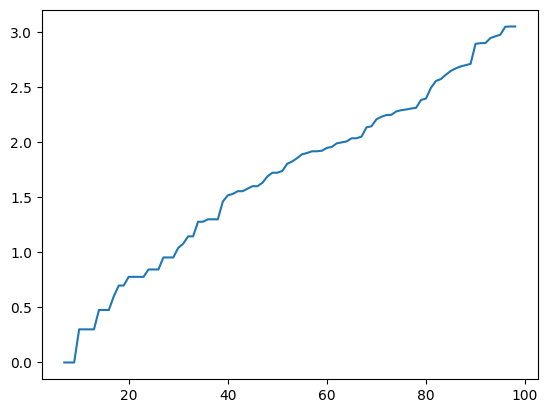

In [95]:
plt.plot(np.arange(len(dop_mass_one)), np.log10(np.sort(dop_mass_one)))

In [96]:
w = np.where(dop_mass_one > -1)[0]
df_dop_desc = pd.DataFrame(list_dop_descript, columns=np.array(dop_desc_name_new, dtype=str)) #first set
print('dop desc', df_dop_desc.shape)
print('left dop feat', len(w))
df_dop_desc = df_dop_desc.iloc[:, w]
print('dop desc new', df_dop_desc.shape)

dop desc (1130, 99)
left dop feat 99
dop desc new (1130, 99)


In [97]:
columns = list(df_dop_desc.columns.values)
columns = [columns[-1]] + columns[:-1]
df_dop_desc = df_dop_desc.loc[:, columns]
df_dop_desc.head(5)

,Urea_dop,Br_dop,F_dop,I_dop,P_dop,N_dop,B_dop,S_dop,O_dop,C_dop,...,Nquat_dop,Sether_dop,Sulfamd_dop,Sulfone_dop,TermCHCH_dop,Tetrazol_dop,Thiazole_dop,RSCN_dop,Thioph_dop,UNb_alk_dop
0,0,0,0,0,0,0,0,0,6,6,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,6,6,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,5,0,1,1,12,...,0,0,0,0,0,0,1,0,0,0
3,0,0,6,0,0,3,0,0,2,18,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,2,17,14,...,0,0,0,0,0,0,0,0,0,0


In [98]:
fragments_list = np.load('BBB_features.npy')
fgraments_list = fragments_list[-474:]
fgraments_list

array(['cc-c(c)ccc', 'ccccs', 'ccccN', 'cccnc', 'cccc(c)-cn', 'csccn',
       'c1cscn1', 'ccsc(n)N', 'cncN', 'cnc(c)-c', 'cccc-c(c)n', 'ccncN',
       'ccc(c)-c(c)n', 'ccc-c(c)nc', 'cccncN', 'ccc(c)-cnc',
       'cnc(c)-c(c)c', 'ccccNC', 'cc(c)CN', 'cnccn', 'ccccn', 'cccc(c)nc',
       'cncNCC', 'cccc(c)CN', 'cnc(c)cn', 'ccccnc', 'ccc(cc)CN',
       'cnc(c)c(c)n', 'cccncNC', 'ccccncN', 'CCO', 'CCOC', 'COC(C)O',
       'CCCO', 'OCCO', 'CCC(C)O', 'CC[C@@H](C)O', 'CCCOC', 'CO[C@H](C)C',
       'CCCOCC', 'cccc(c)N', 'ccccc(c)N', 'cc(-c)ccN', 'ccccc(c)O',
       'cccc(c)CC', 'cccc(c)OC', 'CCC(C)C', 'ccc(c)CCC', 'ccc(c)OCC',
       'cc(c)CCCC', 'CCC(C)CC', 'cc(c)OCCC', 'CCCCO', 'CCC(C)COc',
       'cc(O)cccC', 'cccco', 'cccc(c)cc', 'ccc(cc)OC', 'ccccNCC',
       'cccc(c)NC', 'ccc(N)nc', 'ccccN(C)C', 'CNCCN', 'CCN(C)C',
       'ccc(c)CNC', 'ccc(c)NCC', 'cccncc', 'ccc(n)NCC', 'cc(n)N(C)CC',
       'CNCCN(c)C', 'cccN(C)CC', 'ccc(c)N(C)C', 'CCNCCN', 'CCNCC',
       'CCN(C)CC', 'cc(c)CNCC', 'cc(c

In [99]:
list_main_descript = []
for mol_i in tqdm(df['SMILES']):
    mol_sm = Chem.MolFromSmiles(mol_i)
    mol_frags_list = []
    for ii in range(len(fgraments_list)):
        p = FragmentMatcher.FragmentMatcher()
        p.Init(fgraments_list[ii])
        mol_frags_list.append(len(p.GetMatches(mol_sm)))
    list_main_descript.append(mol_frags_list)

list_main_descript = np.array(list_main_descript)
print(list_main_descript.shape)

100%|██████████| 1130/1130 [00:27<00:00, 40.76it/s]

(1130, 474)


In [100]:
df_main_desc = pd.DataFrame(list_main_descript, columns=fgraments_list)
df_main_desc.describe()

,cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,cnc(c)-c,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,...,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000
mean,0.339823,0.071681,0.749558,1.146018,0.132743,0.040708,0.030973,0.023894,0.177876,0.055752,...,0.024779,0.062832,0.022124,0.043363,0.044248,0.038938,0.122124,0.085841,0.283186,0.321239
std,1.515058,0.407192,1.329679,2.017397,0.725402,0.222967,0.178360,0.179446,0.562519,0.296850,...,0.161114,0.355320,0.147152,0.277397,0.294303,0.253036,0.679412,0.549316,1.000169,0.635801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,4.000000,8.000000,14.000000,8.000000,2.000000,2.000000,2.000000,6.000000,3.000000,...,2.000000,4.000000,1.000000,2.000000,2.000000,2.000000,6.000000,4.000000,7.000000,3.000000


In [101]:
columns = list(df_main_desc.columns.values)
columns = [columns[-1]] + columns[:-1]
df_main_desc = df_main_desc.loc[:, columns]
df_main_desc.head(5)

,c[X],cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,...,ccnCc(c)c,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X]
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,2,3,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
df_full = pd.concat([df_dop_desc, df_main_desc], axis=1)
df_full.shape

(1130, 573)

In [103]:
df = pd.concat([df, df_full], axis=1)
df.head()

,SMILES,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,...,ccnCc(c)c,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X]
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0,0,0,0,0,0,0,0,0,0
1,OCC(O)C(O)C(O)C(O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0,0,0,0,0,0,0,0,0,0
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,19.0,...,0,0,0,0,0,0,0,0,0,0
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,29.0,...,0,0,0,0,0,0,0,0,0,6
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,34.0,...,0,0,0,0,0,0,0,0,0,0


### Estate_VSA

In [104]:
def generate_estate_fpts(data):
    estate_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        estatefpts = VSA_EState_(mol)
        estate_fpts.append(estatefpts)
    return np.array(estate_fpts)

In [105]:
estate_fpts = generate_estate_fpts(df['SMILES'])

100%|██████████| 1130/1130 [00:00<00:00, 1192.87it/s]


In [106]:
estate_fpts.shape

(1130, 10)

In [107]:
for i, row in df.iterrows():
    for j in range(estate_fpts.shape[1]):
        df.at[i, f'E_{j+1}'] = estate_fpts[i][j]

df.head()

,SMILES,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,...,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0.000000,0.000000,52.176914,0.000000,0.000000,0.000000,-6.391944,-1.451636,0.00000,0.000000
1,OCC(O)C(O)C(O)C(O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0.000000,0.000000,52.176914,0.000000,0.000000,0.000000,-6.391944,-1.451636,0.00000,0.000000
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,19.0,...,0.000000,19.201681,5.078830,12.969815,-0.134704,7.406556,0.000000,1.464642,0.00000,1.346513
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,29.0,...,76.408470,19.134407,11.887089,-2.200566,-1.765334,6.596278,-9.113484,-0.113526,0.00000,0.000000
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,34.0,...,84.727417,11.389837,53.051470,0.000000,-0.728697,-1.556118,-16.981647,-1.057560,-10.01137,0.000000


In [108]:
df = df[['MW',
 '#HBA',
 '#HBD',
 'PSA',
 '#ROTB',
 '#ALERTS',
 'MlogP',
 '#MR',
 '#HeavyAtoms',
 '#NHOH',
 '#NO',
 '#AromaticCarbocycles',
 '#AromaticHeterocycles',
 '#Heteroatoms',
 'Morgan2',
 'Morgan3',
 'HeavyAtomMW',
 'MaxPartialCharge',
 'MinPartialCharge',
 '#ValenceElectrons',
 'BertzCT',
 'Br_dop',
 'Cl_dop',
 'C_dop',
 'S_dop',
 'O_dop',
 'F_dop',
 'P_dop',
 'TRIPLE_dop',
 'AROMATIC_dop',
 'DOUBLE_dop',
 'SINGLE_dop',
 'num_atom_dop',
 'AlCOO_dop',
 'AlOH_dop',
 'AlOHnt_dop',
 'ArN_dop',
 'ArCOO_dop',
 'Ar_N_dop',
 'ArNH_dop',
 'ArOH_dop',
 'COO_dop',
 'CO_dop',
 'CS_dop',
 'Imine_dop',
 'NHtert_dop',
 'NHsec_dop',
 'NHpri_dop',
 'XCCNR_dop',
 'TACA_dop',
 'Npyrrl_dop',
 'Alk_carb_dop',
 'Alk_hal_dop',
 'Alk_oxid_dop',
 'Amide_dop',
 'Amidine_dop',
 'Aniline_dop',
 'Barb_dop',
 'Benz_dop',
 'BenzD_dop',
 'Bicycl_dop',
 'Epoxide_dop',
 'Ester_dop',
 'EtherO_dop',
 'Furan_dop',
 'Guanid_dop',
 'Hdrzone_dop',
 'Imidazole_dop',
 'Imide_dop',
 'Ket_dop',
 'Ket2_dop',
 'Lactam_dop',
 'RCN_dop',
 'Nitro_dop',
 'NitroArno_dop',
 'paraHX_dop',
 'PhOH_dop',
 'PhOHno_dop',
 'Piprdn_dop',
 'Piprzn_dop',
 'Priamide_dop',
 'PyrRing_dop',
 'Nquat_dop',
 'TermCHCH_dop',
 'Tetrazol_dop',
 'Thiazole_dop',
 'Thioph_dop',
 'UNb_alk_dop',
 'Urea_dop',
 'ccccs',
 'ccccN',
 'cccnc',
 'cccc(c)-cn',
 'csccn',
 'c1cscn1',
 'ccsc(n)N',
 'cncN',
 'cccc-c(c)n',
 'ccc(c)-c(c)n',
 'ccc(c)-cnc',
 'cnc(c)-c(c)c',
 'ccccNC',
 'cc(c)CN',
 'cnccn',
 'ccccn',
 'cccc(c)nc',
 'cncNCC',
 'cnc(c)cn',
 'ccccnc',
 'ccc(cc)CN',
 'cnc(c)c(c)n',
 'ccccncN',
 'CCO',
 'CCOC',
 'COC(C)O',
 'CCCO',
 'OCCO',
 'CCC(C)O',
 'CC[C@@H](C)O',
 'CCCOC',
 'CO[C@H](C)C',
 'CCCOCC',
 'cccc(c)N',
 'cc(-c)ccN',
 'ccccc(c)O',
 'cccc(c)CC',
 'cccc(c)OC',
 'CCC(C)C',
 'ccc(c)CCC',
 'ccc(c)OCC',
 'cc(c)CCCC',
 'CCC(C)CC',
 'cc(c)OCCC',
 'CCCCO',
 'CCC(C)COc',
 'cc(O)cccC',
 'cccco',
 'cccc(c)cc',
 'ccccNCC',
 'ccc(N)nc',
 'ccccN(C)C',
 'CNCCN',
 'CCN(C)C',
 'ccc(c)CNC',
 'ccc(c)NCC',
 'ccc(n)NCC',
 'cc(n)N(C)CC',
 'ccc(c)N(C)C',
 'CCNCCN',
 'CCNCC',
 'CCN(C)CC',
 'cc(c)CNCC',
 'cc(c)CN(C)C',
 'cccc(n)N',
 'cc(n)N(C)C',
 'CN(cn)CCN',
 'ccN(CC)CC',
 'cc(c)N(C)CC',
 'CCNCCNC',
 'CCN(C)CCN',
 'ccCNCCN',
 'CCCN(C)CC',
 'c1cc[nH]c1',
 'C1CNCCN1',
 'cccc([nH])cc',
 'cncCN',
 'cc(C)cn',
 'cnc(c)n',
 'ccnc(c)C',
 'cnc(n)cn',
 'ccnccC',
 'Cccncn',
 'nccncn',
 'C=CC',
 'C=N',
 'C=CCC',
 'cccc(c)C=N',
 'cc(C)c(c)N',
 'C/C=C\\CC',
 'CC=C(C)CCC',
 'C=CC=C',
 'COc(cC)cc',
 'cccNCCC',
 'cc(C)c(c)NC',
 'CCCCNC',
 'C=C(C)CCCC',
 'CCCCC',
 'cc(c)NCCC',
 'CCCCCC',
 'CCCC(C)CC',
 'CCC[C@@H](C)CC',
 'CCCCCCC',
 'cc(c)Cc(c)c',
 'cccc(c)CO',
 'cccc(C)cC',
 'cccCOC',
 'ccc(cC)CC',
 'ccc(C)c(c)C',
 'cc(c)C[C@@H](C)C',
 'C[C@@H](C)CO',
 'CC[C@H](C)OC',
 'c1cCCCC1',
 'cc(cC)CCC',
 'cc(C)c(c)CC',
 'cc(cCC)CC',
 'cc(C)ccOC',
 'cccCOCC',
 'CCCCOC',
 'CccC[C@@H](C)C',
 'cCCC(C)CC',
 'CccCCCC',
 'cccc(c)Nc',
 'ccc-ccn',
 'ccc(n)-c(c)c',
 'cc-ccnc',
 'ccc-c(c)cc',
 'ccn(c)C',
 'C1CCOC1',
 'CCC[C@@H](C)O',
 'CCCCCO',
 'cc(c)Oc(c)c',
 'ccc(c)CCN',
 'CNC(C)C',
 'CNCCO',
 'ccc-ccC',
 'cc(c)CCNC',
 'CN[C@@H](C)C',
 'CNC[C@@H](C)NC',
 'CCCNC',
 'cc(c)OCCN',
 'CCOCCN',
 'CNCCCN',
 'CCNC(C)C',
 'CCCNCC',
 'CCCCN(C)C',
 'CCN[C@H](C)CN',
 'CCCCNCC',
 'CCCCCCN',
 'CN(C)CCCN',
 'cnnc',
 'ccc(c)-ncn',
 'ccc(c)-ncC',
 'Ccnn',
 'ccnnc',
 'cc(c)-n(c)cn',
 'ccc(c)C(c)=N',
 'Ccncn',
 'c1ncnn1',
 'c[nH]cc(c)C',
 'cc(C)cc(c)[nH]',
 'cc(C)cccC',
 'ccc(c)ccC',
 'ccc[nH]cC',
 'cc(cC)CCO',
 'CCOC(C)c',
 'cc([nH])cccC',
 'CCS',
 'CCSC',
 'CC=N',
 'C=NC',
 'N=C(N)N',
 'NCCS',
 'CSCCN',
 'C=NCC',
 'ccCSCCN',
 'CC[C@H](C)NC',
 'c1c[nH]cn1',
 'CCC(C)(C)CC',
 'C=CC(C)CCC',
 'C=CCC(C)CC',
 'CCC(C)C(C)C',
 'C=C(C)C(C)C',
 'C=C(C)C(C)CC',
 'C=CC(C)(C)CC',
 'C=C(CC)C(C)C',
 'CCC=CCCC',
 'CCC(CC)CC',
 'C=CC(C)C(C)C',
 'C1CCCCC1',
 'C=CC(CC)CC',
 'CC(C)CC(C)C',
 'NS',
 'cc-cnn',
 'c1cnc[nH]c1',
 'CCN(CC)CC',
 'ccc(c)C(C)C',
 'CC(C)cn',
 'cc(c)C(C)CC',
 'cc(n)cn(c)C',
 'cn(C)ccn',
 'ccc(c)c(c)c',
 'C=Nccc',
 'cN=CN',
 'CNC(=N)N',
 'CCNC(=N)N',
 'CCNCNC',
 'ccc(c)NCN',
 'CN=CNC',
 'cccn(C)cC',
 'CcnCC',
 'cccc(c)nC',
 'cc-c(c)ncc',
 'CccccnC',
 'ccccnCC',
 'CNCCCO',
 'CCNCCCO',
 'CCC[C@H](C)NC',
 'CCN(C)[C@@H](C)C',
 'CC[C@@H](O)CCN',
 'CN1CCCC1',
 'CCCC[C@@H](C)O',
 'CN(C)CCCO',
 'C1CCNCC1',
 'CCCC[C@H](C)N',
 'CCN[C@@H](C)CC',
 'CCCN[C@@H](C)C',
 'C[C@@H]1CCCN1',
 'CCCCCOC',
 'ccCNCcc',
 'cnn(c)C',
 'c1cnnc1',
 'c1ccoc1',
 'CCCCcn',
 'cncNCCC',
 'cc(C)cc(c)C',
 'cncccN',
 'cNCCN(C)C',
 'ccCCCCC',
 'cCCCCCC',
 'cCC(CC)CC',
 'cc(N)c(c)CC',
 'cc(cN)CCC',
 'cc(C)cNCC',
 'C[C@H](C)C(C)CO',
 'cc(c)CCCN',
 'ccc(c)n(c)C',
 'cnc(C)nC',
 'CCC(C)CNC',
 'cc(n)c(c)nC',
 'cCCCN(C)C',
 'CC(C)CN(C)C',
 'CccCCCN',
 'ccCCCNC',
 'cc(c)ncnC',
 'cc(C)cccn',
 'ccc(C)ccn',
 'ccc(c)/C=C\\C',
 'CccCN',
 'cc(C)cCCN',
 'ccCNCCc',
 'ccCNC(C)C',
 'ccCCNCC',
 'CCC(C)CCN',
 'CCCN(C)Cc',
 'C=CCNC',
 'C=CCN(C)C',
 'CCC(CN)NC',
 'C=CCCN(C)C',
 'CC(N)CN(C)C',
 'C=CCCNCC',
 'cCC(C)N(C)C',
 'C=CN',
 'CNC(C)C(C)C',
 'CC(C)CCCN',
 'CCCC(C)CN',
 'CC=CC(C)CC',
 'cc(c)C(C)CN',
 'ccC(C)CCC',
 'cccC(C)CN',
 'ccC(C)CNC',
 'CCNCC(c)C',
 'CCNCCO',
 'CCN(C)CCO',
 'ccncc(c)c',
 'cc(cNC)CC',
 'ccNCCCN',
 'ccNCC(C)C',
 'CNCCCCN',
 'ccCC(C)NC',
 'ccC(C)CCN',
 'ccC(CC)CC',
 'CCCCCNc',
 'CCC(C)CNc',
 'CNC(C)CCN',
 'CC(CN)CCN',
 'CccC[C@H](C)N',
 'ccC(C)(C)CC',
 'CCCC(C)(C)c',
 'ccCC(N)CC',
 'cc(N)cccO',
 'ccOCCCN',
 'cc(c)NCCN',
 'CCCC(C)CO',
 'cc(c)C(N)CC',
 'cc(c)ccc-c',
 'cc(n)ccn',
 'cCNC(C)CN',
 'CCCCNCc',
 'CC(N)CCCN',
 'cCCCC(C)C',
 'ccc(c)Cnc',
 'cc(C)c(C)cO',
 'Ccc(C)cOC',
 'CCCNCCO',
 'cNC(C)CCN',
 'CNCCCCO',
 'CC(CO)CCN',
 'cc(c)C(C)CO',
 'CCC(C)C(C)c',
 'cc1cOCC1',
 'cc(O)c(c)CC',
 'cc(C)cC(C)C',
 'CccC(C)CO',
 'CCc(cC)cO',
 'cc(cO)C(C)C',
 'cc(CC)cOC',
 'NCCcccO',
 'cCC(N)C(C)C',
 'CCOcccC',
 'cc(C)cCCO',
 'cC(CO)CCN',
 'CCC(C)ccO',
 'ccN(C)CCC',
 'COCCNC',
 'cc(c)C(N)CN',
 'CCC(CN)CN',
 'cc(c)N(c)CC',
 'ccnCc(c)c',
 'CCCCC(c)N',
 'CNC(C)C(c)N',
 'ccc(S)c(c)N',
 'cc(S)c(c)NC',
 'CCC(c)[C@@H](C)C',
 'CC(C)CNCN',
 'c[X]',
 'E_1',
 'E_2',
 'E_3',
 'E_4',
 'E_5',
 'E_6',
 'E_7',
 'E_8',
 'E_9', 'SMILES']]

In [109]:
df.head()

,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,#NHOH,...,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,SMILES
0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,6.0,...,0.000000,0.000000,52.176914,0.000000,0.000000,0.000000,-6.391944,-1.451636,0.00000,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
1,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,6.0,...,0.000000,0.000000,52.176914,0.000000,0.000000,0.000000,-6.391944,-1.451636,0.00000,OCC(O)C(O)C(O)C(O)CO
2,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,19.0,5.0,...,0.000000,19.201681,5.078830,12.969815,-0.134704,7.406556,0.000000,1.464642,0.00000,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1
3,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,29.0,2.0,...,76.408470,19.134407,11.887089,-2.200566,-1.765334,6.596278,-9.113484,-0.113526,0.00000,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...
4,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,34.0,8.0,...,84.727417,11.389837,53.051470,0.000000,-0.728697,-1.556118,-16.981647,-1.057560,-10.01137,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...


### **Class label prediction**

In [110]:
class_pretrained_df = pd.read_csv('fragments_classification_actual.csv')
class_pretrained_df.head()

,Activity,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,...,c[X],E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9
0,1,252.73,0.0,0.0,0.00,0.0,1.0,2.45,30.57,4.0,...,0,0.270833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1,98.14,1.0,1.0,20.23,1.0,1.0,0.78,29.75,7.0,...,0,0.000000,0.000000,8.895833,-0.888889,2.246528,0.000000,5.531389,3.465139,0.0
2,1,144.60,1.0,1.0,20.23,2.0,1.0,1.51,39.07,9.0,...,0,0.000000,0.000000,9.221389,0.074514,2.213333,0.000000,6.856096,1.788441,0.0
3,1,175.19,2.0,1.0,52.32,2.0,1.0,1.46,48.68,13.0,...,0,4.688287,10.446373,0.000000,5.589179,2.326620,9.010249,3.605958,0.000000,0.0
4,1,360.47,4.0,1.0,35.94,6.0,1.0,2.66,101.66,26.0,...,1,19.006491,4.491719,10.364971,0.572907,2.614048,6.624001,10.376729,4.365801,0.0


In [111]:
X_class = class_pretrained_df.iloc[:, 1:].values

In [112]:
class_scaler = StandardScaler().fit(X_class)

In [113]:
classification_model = joblib.load('best_classification_model.joblib')

In [114]:
X = df.iloc[:, :-1].values

In [115]:
X = class_scaler.transform(X)

In [116]:
y_pred_class = classification_model.predict(X)

In [117]:
df['Class'] = y_pred_class
df.head()

,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,#NHOH,...,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,SMILES,Class
0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,6.0,...,0.000000,52.176914,0.000000,0.000000,0.000000,-6.391944,-1.451636,0.00000,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,0
1,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,6.0,...,0.000000,52.176914,0.000000,0.000000,0.000000,-6.391944,-1.451636,0.00000,OCC(O)C(O)C(O)C(O)CO,0
2,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,19.0,5.0,...,19.201681,5.078830,12.969815,-0.134704,7.406556,0.000000,1.464642,0.00000,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,1
3,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,29.0,2.0,...,19.134407,11.887089,-2.200566,-1.765334,6.596278,-9.113484,-0.113526,0.00000,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,0
4,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,34.0,8.0,...,11.389837,53.051470,0.000000,-0.728697,-1.556118,-16.981647,-1.057560,-10.01137,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,0


In [118]:
df[['SMILES', 'Class']].to_csv('Class_labels.csv', index=False)

### **LogBB value prediction**

In [119]:
reg_pretrained_df = pd.read_csv('pubchem_regression_actual.csv')
reg_pretrained_df.head()

,Class,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,...,PUBCHEM_841,PUBCHEM_842,PUBCHEM_845,PUBCHEM_846,PUBCHEM_848,PUBCHEM_866,PUBCHEM_867,PUBCHEM_869,PUBCHEM_874,Activity
0,0.0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.60
1,0.0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.60
2,0.0,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.57
3,0.0,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.57
4,0.0,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.54


In [141]:
X_reg = reg_pretrained_df.iloc[:, :-1].values

In [143]:
reg_scaler = StandardScaler().fit(X_reg)

In [122]:
df = rdkit_df
df.head()

,SMILES,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,...,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons,BertzCT,Kappa1
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0,104.61,11.76
1,OCC(O)C(O)C(O)C(O)CO,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,12.0,...,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0,104.61,11.76
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,19.0,...,1.0,7.0,2.21,2.89,262.23,0.220748,-0.369771,98.0,630.55,13.03
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,29.0,...,1.0,11.0,1.45,2.00,404.21,0.415990,-0.476407,152.0,1062.11,20.37
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,34.0,...,0.0,20.0,1.35,1.85,518.28,0.396945,-0.387946,200.0,911.18,29.12


In [123]:
df.insert(1, 'Class', y_pred_class)
df.head()

,SMILES,Class,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,...,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons,BertzCT,Kappa1
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,...,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0,104.61,11.76
1,OCC(O)C(O)C(O)C(O)CO,0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,...,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0,104.61,11.76
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,...,1.0,7.0,2.21,2.89,262.23,0.220748,-0.369771,98.0,630.55,13.03
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,0,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,...,1.0,11.0,1.45,2.00,404.21,0.415990,-0.476407,152.0,1062.11,20.37
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,0,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,...,0.0,20.0,1.35,1.85,518.28,0.396945,-0.387946,200.0,911.18,29.12


In [124]:
def generate_pubchem(data):
    rows_to_del = []
    pubchem_features = []
    idx = 0
    for smi in tqdm((list(data))):
        try:
            cid = get_cids(smi, 'smiles')[0]
            # print(cid)
            if cid == 0:
                rows_to_del.append(idx)
            else:
                features_dict = Compound.from_cid(cid).to_dict()
                descriptors = [features_dict['atom_stereo_count'], features_dict['bond_stereo_count'],
                               features_dict['complexity'], features_dict['covalent_unit_count'],
                               features_dict['isotope_atom_count']
                              ]
                fingerprints = [int(fp) for fp in list(features_dict['cactvs_fingerprint'])]
                pubchem_features.append(descriptors + fingerprints)
        except:
            rows_to_del.append(idx)
            # print('hey')
        idx = idx + 1
    return np.array(pubchem_features), rows_to_del

In [125]:
pubchem_features, rows_to_del = generate_pubchem(df['SMILES'])

100%|██████████| 1130/1130 [15:55<00:00,  1.18it/s]


In [126]:
for i in rows_to_del:
    df = df.drop(labels=[i], axis=0)

In [127]:
df.shape

(1015, 24)

In [128]:
df = df.reset_index(drop=True)

In [129]:
number = 0
for i, row in df.iterrows():
    for j in range(pubchem_features.shape[1]):
        df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
    number = number + 1

<ipython-input-129-081f9c247e91>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
<ipython-input-129-081f9c247e91>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
<ipython-input-129-081f9c247e91>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [130]:
df.head()

,SMILES,Class,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,...,PUBCHEM_877,PUBCHEM_878,PUBCHEM_879,PUBCHEM_880,PUBCHEM_881,PUBCHEM_882,PUBCHEM_883,PUBCHEM_884,PUBCHEM_885,PUBCHEM_886
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OCC(O)C(O)C(O)C(O)CO,0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,0,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,0,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
df.tail()

,SMILES,Class,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,...,PUBCHEM_877,PUBCHEM_878,PUBCHEM_879,PUBCHEM_880,PUBCHEM_881,PUBCHEM_882,PUBCHEM_883,PUBCHEM_884,PUBCHEM_885,PUBCHEM_886
1010,Nc1c2c(nc3ccccc13)CCCC2,1,198.27,2.0,1.0,38.91,0.0,0.0,2.70,62.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1011,Clc1cc(Br)cc(Cl)c1N=C1NCCN1,1,308.99,2.0,2.0,36.42,1.0,0.0,2.94,67.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1012,CC(Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCNCC3)...,0,505.59,4.0,2.0,54.77,6.0,0.0,6.81,140.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013,CC(C)CC1C(=O)N2CCCC2C2OC(NC(=O)C3C=C4c5cccc6[n...,0,638.61,5.0,2.0,97.98,5.0,0.0,3.87,163.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1014,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0,871.91,14.0,4.0,221.29,10.0,3.0,3.87,217.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
df = df[[
 'SMILES',
 'Class',
 'MW',
 '#HBA',
 '#HBD',
 'PSA',
 '#ROTB',
 '#ALERTS',
 'MlogP',
 '#MR',
 '#HeavyAtoms',
 '#NHOH',
 '#NO',
 '#AromaticCarbocycles',
 '#AromaticHeterocycles',
 '#Heteroatoms',
 'Morgan2',
 'HeavyAtomMW',
 'MaxPartialCharge',
 'MinPartialCharge',
 '#ValenceElectrons',
 'BertzCT',
 'Kappa1',
 'PUBCHEM_1',
 'PUBCHEM_2',
 'PUBCHEM_3',
 'PUBCHEM_6',
 'PUBCHEM_7',
 'PUBCHEM_8',
 'PUBCHEM_12',
 'PUBCHEM_15',
 'PUBCHEM_16',
 'PUBCHEM_17',
 'PUBCHEM_18',
 'PUBCHEM_19',
 'PUBCHEM_20',
 'PUBCHEM_22',
 'PUBCHEM_23',
 'PUBCHEM_24',
 'PUBCHEM_25',
 'PUBCHEM_26',
 'PUBCHEM_27',
 'PUBCHEM_29',
 'PUBCHEM_30',
 'PUBCHEM_39',
 'PUBCHEM_43',
 'PUBCHEM_45',
 'PUBCHEM_50',
 'PUBCHEM_53',
 'PUBCHEM_121',
 'PUBCHEM_122',
 'PUBCHEM_124',
 'PUBCHEM_135',
 'PUBCHEM_142',
 'PUBCHEM_149',
 'PUBCHEM_150',
 'PUBCHEM_156',
 'PUBCHEM_158',
 'PUBCHEM_159',
 'PUBCHEM_166',
 'PUBCHEM_184',
 'PUBCHEM_185',
 'PUBCHEM_187',
 'PUBCHEM_191',
 'PUBCHEM_192',
 'PUBCHEM_193',
 'PUBCHEM_198',
 'PUBCHEM_199',
 'PUBCHEM_201',
 'PUBCHEM_205',
 'PUBCHEM_207',
 'PUBCHEM_212',
 'PUBCHEM_213',
 'PUBCHEM_219',
 'PUBCHEM_220',
 'PUBCHEM_221',
 'PUBCHEM_222',
 'PUBCHEM_226',
 'PUBCHEM_233',
 'PUBCHEM_235',
 'PUBCHEM_236',
 'PUBCHEM_240',
 'PUBCHEM_248',
 'PUBCHEM_250',
 'PUBCHEM_254',
 'PUBCHEM_255',
 'PUBCHEM_257',
 'PUBCHEM_261',
 'PUBCHEM_262',
 'PUBCHEM_263',
 'PUBCHEM_265',
 'PUBCHEM_267',
 'PUBCHEM_268',
 'PUBCHEM_282',
 'PUBCHEM_289',
 'PUBCHEM_290',
 'PUBCHEM_291',
 'PUBCHEM_292',
 'PUBCHEM_303',
 'PUBCHEM_304',
 'PUBCHEM_305',
 'PUBCHEM_306',
 'PUBCHEM_333',
 'PUBCHEM_334',
 'PUBCHEM_335',
 'PUBCHEM_336',
 'PUBCHEM_337',
 'PUBCHEM_338',
 'PUBCHEM_339',
 'PUBCHEM_340',
 'PUBCHEM_341',
 'PUBCHEM_342',
 'PUBCHEM_343',
 'PUBCHEM_344',
 'PUBCHEM_345',
 'PUBCHEM_346',
 'PUBCHEM_347',
 'PUBCHEM_349',
 'PUBCHEM_350',
 'PUBCHEM_351',
 'PUBCHEM_352',
 'PUBCHEM_353',
 'PUBCHEM_355',
 'PUBCHEM_356',
 'PUBCHEM_357',
 'PUBCHEM_359',
 'PUBCHEM_361',
 'PUBCHEM_362',
 'PUBCHEM_363',
 'PUBCHEM_364',
 'PUBCHEM_365',
 'PUBCHEM_366',
 'PUBCHEM_367',
 'PUBCHEM_369',
 'PUBCHEM_370',
 'PUBCHEM_371',
 'PUBCHEM_372',
 'PUBCHEM_373',
 'PUBCHEM_374',
 'PUBCHEM_376',
 'PUBCHEM_377',
 'PUBCHEM_378',
 'PUBCHEM_379',
 'PUBCHEM_380',
 'PUBCHEM_381',
 'PUBCHEM_382',
 'PUBCHEM_383',
 'PUBCHEM_384',
 'PUBCHEM_387',
 'PUBCHEM_388',
 'PUBCHEM_389',
 'PUBCHEM_390',
 'PUBCHEM_391',
 'PUBCHEM_393',
 'PUBCHEM_394',
 'PUBCHEM_395',
 'PUBCHEM_396',
 'PUBCHEM_397',
 'PUBCHEM_398',
 'PUBCHEM_399',
 'PUBCHEM_400',
 'PUBCHEM_401',
 'PUBCHEM_402',
 'PUBCHEM_403',
 'PUBCHEM_404',
 'PUBCHEM_405',
 'PUBCHEM_406',
 'PUBCHEM_407',
 'PUBCHEM_409',
 'PUBCHEM_410',
 'PUBCHEM_411',
 'PUBCHEM_414',
 'PUBCHEM_418',
 'PUBCHEM_420',
 'PUBCHEM_422',
 'PUBCHEM_424',
 'PUBCHEM_425',
 'PUBCHEM_426',
 'PUBCHEM_427',
 'PUBCHEM_428',
 'PUBCHEM_429',
 'PUBCHEM_433',
 'PUBCHEM_434',
 'PUBCHEM_435',
 'PUBCHEM_437',
 'PUBCHEM_438',
 'PUBCHEM_440',
 'PUBCHEM_441',
 'PUBCHEM_442',
 'PUBCHEM_443',
 'PUBCHEM_444',
 'PUBCHEM_445',
 'PUBCHEM_446',
 'PUBCHEM_447',
 'PUBCHEM_449',
 'PUBCHEM_451',
 'PUBCHEM_452',
 'PUBCHEM_453',
 'PUBCHEM_454',
 'PUBCHEM_455',
 'PUBCHEM_456',
 'PUBCHEM_457',
 'PUBCHEM_458',
 'PUBCHEM_459',
 'PUBCHEM_461',
 'PUBCHEM_463',
 'PUBCHEM_465',
 'PUBCHEM_466',
 'PUBCHEM_467',
 'PUBCHEM_468',
 'PUBCHEM_471',
 'PUBCHEM_472',
 'PUBCHEM_473',
 'PUBCHEM_474',
 'PUBCHEM_476',
 'PUBCHEM_477',
 'PUBCHEM_479',
 'PUBCHEM_480',
 'PUBCHEM_481',
 'PUBCHEM_482',
 'PUBCHEM_483',
 'PUBCHEM_484',
 'PUBCHEM_486',
 'PUBCHEM_488',
 'PUBCHEM_489',
 'PUBCHEM_491',
 'PUBCHEM_492',
 'PUBCHEM_494',
 'PUBCHEM_495',
 'PUBCHEM_497',
 'PUBCHEM_498',
 'PUBCHEM_499',
 'PUBCHEM_500',
 'PUBCHEM_501',
 'PUBCHEM_502',
 'PUBCHEM_503',
 'PUBCHEM_504',
 'PUBCHEM_505',
 'PUBCHEM_506',
 'PUBCHEM_507',
 'PUBCHEM_508',
 'PUBCHEM_510',
 'PUBCHEM_511',
 'PUBCHEM_514',
 'PUBCHEM_516',
 'PUBCHEM_517',
 'PUBCHEM_520',
 'PUBCHEM_522',
 'PUBCHEM_523',
 'PUBCHEM_524',
 'PUBCHEM_525',
 'PUBCHEM_527',
 'PUBCHEM_528',
 'PUBCHEM_529',
 'PUBCHEM_530',
 'PUBCHEM_532',
 'PUBCHEM_534',
 'PUBCHEM_535',
 'PUBCHEM_536',
 'PUBCHEM_537',
 'PUBCHEM_539',
 'PUBCHEM_541',
 'PUBCHEM_542',
 'PUBCHEM_543',
 'PUBCHEM_544',
 'PUBCHEM_549',
 'PUBCHEM_550',
 'PUBCHEM_551',
 'PUBCHEM_553',
 'PUBCHEM_554',
 'PUBCHEM_556',
 'PUBCHEM_557',
 'PUBCHEM_558',
 'PUBCHEM_559',
 'PUBCHEM_560',
 'PUBCHEM_561',
 'PUBCHEM_562',
 'PUBCHEM_564',
 'PUBCHEM_565',
 'PUBCHEM_568',
 'PUBCHEM_570',
 'PUBCHEM_571',
 'PUBCHEM_572',
 'PUBCHEM_573',
 'PUBCHEM_574',
 'PUBCHEM_575',
 'PUBCHEM_576',
 'PUBCHEM_577',
 'PUBCHEM_578',
 'PUBCHEM_579',
 'PUBCHEM_580',
 'PUBCHEM_581',
 'PUBCHEM_582',
 'PUBCHEM_583',
 'PUBCHEM_584',
 'PUBCHEM_585',
 'PUBCHEM_586',
 'PUBCHEM_587',
 'PUBCHEM_588',
 'PUBCHEM_589',
 'PUBCHEM_590',
 'PUBCHEM_591',
 'PUBCHEM_592',
 'PUBCHEM_594',
 'PUBCHEM_595',
 'PUBCHEM_596',
 'PUBCHEM_597',
 'PUBCHEM_598',
 'PUBCHEM_599',
 'PUBCHEM_600',
 'PUBCHEM_601',
 'PUBCHEM_602',
 'PUBCHEM_603',
 'PUBCHEM_604',
 'PUBCHEM_605',
 'PUBCHEM_606',
 'PUBCHEM_607',
 'PUBCHEM_608',
 'PUBCHEM_609',
 'PUBCHEM_610',
 'PUBCHEM_611',
 'PUBCHEM_612',
 'PUBCHEM_613',
 'PUBCHEM_615',
 'PUBCHEM_616',
 'PUBCHEM_617',
 'PUBCHEM_618',
 'PUBCHEM_619',
 'PUBCHEM_620',
 'PUBCHEM_621',
 'PUBCHEM_622',
 'PUBCHEM_624',
 'PUBCHEM_625',
 'PUBCHEM_626',
 'PUBCHEM_627',
 'PUBCHEM_628',
 'PUBCHEM_629',
 'PUBCHEM_630',
 'PUBCHEM_632',
 'PUBCHEM_634',
 'PUBCHEM_635',
 'PUBCHEM_637',
 'PUBCHEM_638',
 'PUBCHEM_639',
 'PUBCHEM_640',
 'PUBCHEM_641',
 'PUBCHEM_642',
 'PUBCHEM_643',
 'PUBCHEM_644',
 'PUBCHEM_645',
 'PUBCHEM_646',
 'PUBCHEM_649',
 'PUBCHEM_650',
 'PUBCHEM_651',
 'PUBCHEM_653',
 'PUBCHEM_654',
 'PUBCHEM_656',
 'PUBCHEM_658',
 'PUBCHEM_659',
 'PUBCHEM_660',
 'PUBCHEM_661',
 'PUBCHEM_662',
 'PUBCHEM_663',
 'PUBCHEM_664',
 'PUBCHEM_665',
 'PUBCHEM_666',
 'PUBCHEM_667',
 'PUBCHEM_668',
 'PUBCHEM_669',
 'PUBCHEM_671',
 'PUBCHEM_672',
 'PUBCHEM_673',
 'PUBCHEM_674',
 'PUBCHEM_675',
 'PUBCHEM_676',
 'PUBCHEM_677',
 'PUBCHEM_678',
 'PUBCHEM_679',
 'PUBCHEM_680',
 'PUBCHEM_681',
 'PUBCHEM_682',
 'PUBCHEM_683',
 'PUBCHEM_684',
 'PUBCHEM_685',
 'PUBCHEM_686',
 'PUBCHEM_687',
 'PUBCHEM_688',
 'PUBCHEM_689',
 'PUBCHEM_690',
 'PUBCHEM_691',
 'PUBCHEM_692',
 'PUBCHEM_693',
 'PUBCHEM_694',
 'PUBCHEM_695',
 'PUBCHEM_696',
 'PUBCHEM_699',
 'PUBCHEM_700',
 'PUBCHEM_701',
 'PUBCHEM_702',
 'PUBCHEM_703',
 'PUBCHEM_704',
 'PUBCHEM_705',
 'PUBCHEM_706',
 'PUBCHEM_707',
 'PUBCHEM_708',
 'PUBCHEM_712',
 'PUBCHEM_713',
 'PUBCHEM_714',
 'PUBCHEM_715',
 'PUBCHEM_716',
 'PUBCHEM_717',
 'PUBCHEM_718',
 'PUBCHEM_719',
 'PUBCHEM_723',
 'PUBCHEM_725',
 'PUBCHEM_727',
 'PUBCHEM_730',
 'PUBCHEM_731',
 'PUBCHEM_732',
 'PUBCHEM_734',
 'PUBCHEM_735',
 'PUBCHEM_736',
 'PUBCHEM_741',
 'PUBCHEM_744',
 'PUBCHEM_746',
 'PUBCHEM_748',
 'PUBCHEM_755',
 'PUBCHEM_756',
 'PUBCHEM_757',
 'PUBCHEM_758',
 'PUBCHEM_759',
 'PUBCHEM_760',
 'PUBCHEM_761',
 'PUBCHEM_762',
 'PUBCHEM_764',
 'PUBCHEM_765',
 'PUBCHEM_773',
 'PUBCHEM_778',
 'PUBCHEM_779',
 'PUBCHEM_786',
 'PUBCHEM_787',
 'PUBCHEM_788',
 'PUBCHEM_790',
 'PUBCHEM_791',
 'PUBCHEM_793',
 'PUBCHEM_794',
 'PUBCHEM_795',
 'PUBCHEM_799',
 'PUBCHEM_804',
 'PUBCHEM_807',
 'PUBCHEM_809',
 'PUBCHEM_811',
 'PUBCHEM_815',
 'PUBCHEM_816',
 'PUBCHEM_818',
 'PUBCHEM_819',
 'PUBCHEM_822',
 'PUBCHEM_824',
 'PUBCHEM_826',
 'PUBCHEM_828',
 'PUBCHEM_829',
 'PUBCHEM_839',
 'PUBCHEM_840',
 'PUBCHEM_841',
 'PUBCHEM_842',
 'PUBCHEM_845',
 'PUBCHEM_846',
 'PUBCHEM_848',
 'PUBCHEM_866',
 'PUBCHEM_867',
 'PUBCHEM_869',
 'PUBCHEM_874',
]]

In [133]:
df.head()

,SMILES,Class,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,...,PUBCHEM_840,PUBCHEM_841,PUBCHEM_842,PUBCHEM_845,PUBCHEM_846,PUBCHEM_848,PUBCHEM_866,PUBCHEM_867,PUBCHEM_869,PUBCHEM_874
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OCC(O)C(O)C(O)C(O)CO,0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,0,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,0,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
regression_model = joblib.load('best_regression_model.joblib')

In [136]:
X = df.iloc[:, 1:].values

In [144]:
X = reg_scaler.transform(X)

In [145]:
y_pred_reg = regression_model.predict(X)

In [146]:
df['logBB'] = y_pred_reg
df.head()

<ipython-input-146-d74e5a53e86d>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['logBB'] = y_pred_reg


,SMILES,Class,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,...,PUBCHEM_841,PUBCHEM_842,PUBCHEM_845,PUBCHEM_846,PUBCHEM_848,PUBCHEM_866,PUBCHEM_867,PUBCHEM_869,PUBCHEM_874,logBB
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.341114
1,OCC(O)C(O)C(O)C(O)CO,0,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.341114
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,1,275.34,4.0,3.0,106.39,3.0,2.0,1.67,77.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.438339
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,0,415.29,5.0,2.0,75.11,4.0,1.0,4.98,90.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.202234
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,0,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.304280


In [147]:
df[['SMILES', 'logBB']].to_csv('LogBB_values.csv', index=False)

In [148]:
df[['SMILES', 'Class', 'logBB']].to_csv('Class_and_logBB.csv', index=False)